In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings

In [2]:
data=pd.read_csv('monthly-sunspots.csv')

In [3]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')

In [4]:
data.describe()

,Sunspots
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


In [5]:
data

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2815,1983-08-01,71.8
2816,1983-09-01,50.3
2817,1983-10-01,55.8
2818,1983-11-01,33.3


In [6]:
data['Year'] = data['Month'].dt.strftime('%Y').astype(int)
data=data[['Sunspots', 'Year']].groupby('Year').sum()
data.head()

,Sunspots
Year,
1749,971.1
1750,1000.7
1751,571.9
1752,573.6
1753,368.3


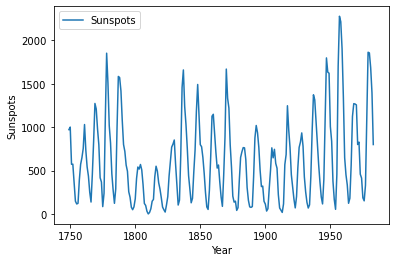

In [7]:
ax=data.plot()
ax.set_ylabel('Sunspots')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(data['Sunspots'])
print(result)
pvalue=result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')

(-2.37975524566571, 0.14753205186316093, 8, 226, {'1%': -3.4596204846395824, '5%': -2.8744153028455948, '10%': -2.5736320761218576}, 2932.3505197084223)
not stationary


C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


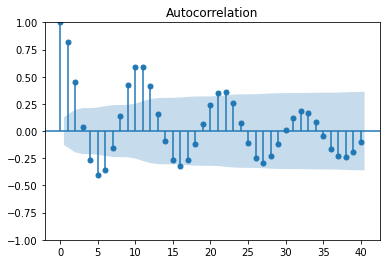

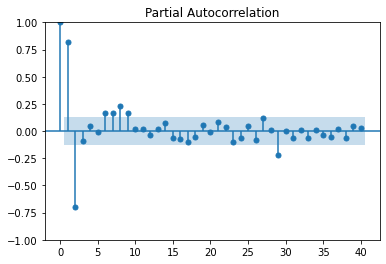

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Sunspots'], lags=40)
plot_pacf(data['Sunspots'], lags=40)
plt.show()

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.8238010790458744


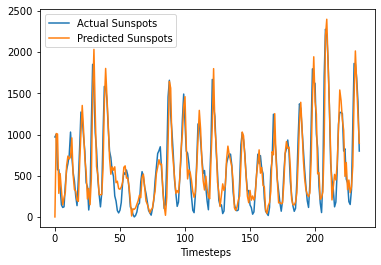

In [10]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
mod=ARIMA(list(data['Sunspots']), order=(2,1,2))
res=mod.fit()
pred=res.predict()
print(r2_score(data, pred))
plt.plot(list(data['Sunspots']))
plt.plot(pred)
plt.legend(['Actual Sunspots', 'Predicted Sunspots']) 
plt.xlabel('Timesteps ')
plt.show()

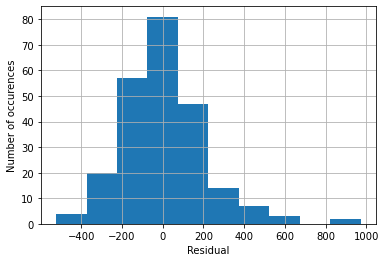

In [11]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Residual')
plt.show()

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  235
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1565.326
Date:                Thu, 14 Mar 2024   AIC                           3140.653
Time:                        14:19:17   BIC                           3157.929
Sample:                             0   HQIC                          3147.619
                                - 235                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5919      0.037     42.873      0.000       1.519       1.665
ar.L2         -0.9240      0.032    -28.788      0.000      -0.987      -0.861
ma.L1         -1.4580      0.071    -20.476      0.000      -1.598      -1.318
ma.L2          0.5735      0.076      7.592      0.000       0.425       0.722
sigma2      3.741e+04   2918.346     12.820      0.000    3.17e+04    4.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):                47.65
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.71
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")
data_array = data.values
avg_errors = []
for p in range(3):
    for q in range(3):
        errors = []
        tscv = TimeSeriesSplit(test_size=10)
        for train_index, test_index in tscv.split(data_array):
            X_train, X_test = data_array[train_index], data_array[test_index]
            X_test_orig = X_test
            fcst = []
            for step in range(10):
                try:
                    mod = ARIMA(X_train, order=(p, 0, q))
                    res = mod.fit()
                    fcst.append(res.forecast(steps=1))
                except:
                    print('error')
                    fcst.append(-9999999)    
            X_train = np.concatenate((X_train, X_test[0:1, :]))
            X_test = X_test[1:]
            errors.append(r2_score(X_test_orig, fcst))
        pq_result = [p, q, np.mean(errors)]
        print(pq_result)
        avg_errors.append(pq_result)
avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'q', 'error']
result = avg_errors.pivot(index='p', columns='q', values='error')


[0, 0, -0.3217534983412461]
[0, 1, -0.8000838464186296]
[0, 2, -1.2807633647119467]
[1, 0, -1.1234106820471097]
[1, 1, -1.329927583015944]
[1, 2, -1.3371853409651524]
[2, 0, -1.388826551273242]
[2, 1, -1.4137270897835612]
[2, 2, -1.3662731580263308]


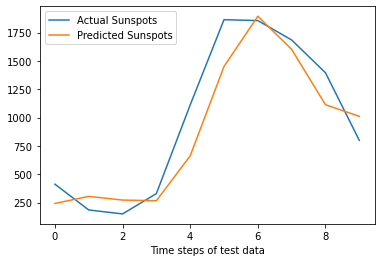

In [14]:
data_array = data.values
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test
fcst = []
for step in range(10):
    mod = ARIMA(X_train, order=(10,0,9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test=X_test[1:]
plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time steps of test data')
plt.show()